# Dust and gas maps

Documentation on dust maps: https://dustmaps.readthedocs.io/en/latest/installation.html

Installing Dust Maps library: pip install dustmaps


More info on dust maps: http://argonaut.skymaps.info/usage

This tutorial 
- gets E(B-V) from dust maps
- converts E(B-V) to $A_V$
- plots the dust maps
- downloads a neutral hydrogen column density map for the same region N(HI)
- compares the two data sets. 

Documentation on skyview: https://astroquery.readthedocs.io/en/latest/skyview/skyview.html 


Satrdards things for coordinates stuff, first three libraries

two later libraries are for collecting data from source


In [2]:
from astropy.coordinates import SkyCoord
import astropy.units as units
from dustmaps.bayestar import BayestarQuery

from dustmaps.sfd import SFDWebQuery
from dustmaps.bayestar import BayestarWebQuery

from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.skyview import SkyView
from astropy.wcs import WCS

In [3]:
# from dustmaps.config import config
# config.reset()

In [4]:
# test query

#bayestar = BayestarQuery(version='bayestar2019') # 'bayestar2019' is the default
#coords = SkyCoord(119.*units.deg, 3.*units.deg, distance=1000.*units.pc, frame='galactic')
 
#reddening = bayestar(coords, mode='median')
#print(reddening)

## Plotting maps

example from:
https://dustmaps.readthedocs.io/en/latest/examples.html

## Doing a Web based Query to get dust maps

In [5]:
from __future__ import print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as units
from astropy.coordinates import SkyCoord

from dustmaps.sfd import SFDQuery
from dustmaps.planck import PlanckQuery
from dustmaps.bayestar import BayestarQuery

In [6]:
# the edge of the Aql south molecular cloud

c_g = SkyCoord(l=37*u.degree, b=-20*u.degree, frame='galactic')
c_g.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (302.51505385, -5.54491684)>

In [7]:
ra0, dec0 = (302., -5.)
ra = np.arange(ra0 - 4., ra0 + 4., 0.05)
dec = np.arange(dec0 - 4., dec0 + 4., 0.05)
ra, dec = np.meshgrid(ra, dec)
coords = SkyCoord(ra*units.deg, dec*units.deg,
                  distance=1.*units.kpc, frame='icrs')

In [8]:
sfd = SFDWebQuery()

# convert E(B-V) to A_v
Av_sfd = 2.742 * sfd(coords)

bayestar = BayestarWebQuery()

# convert E(B-V) to A_v
Av_bayestar = 2.742 * bayestar(coords)

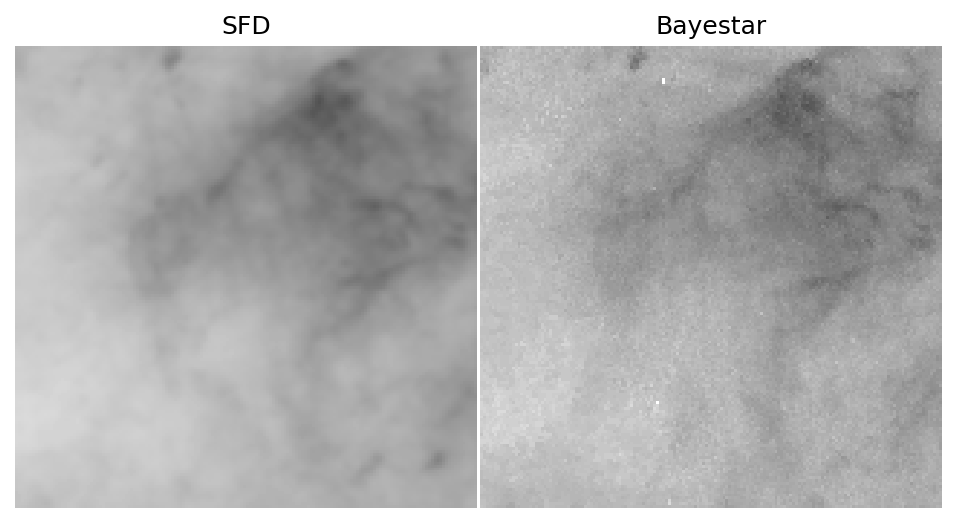

In [9]:
fig = plt.figure(figsize=(12,4), dpi=150)

for k,(Av,title) in enumerate([(Av_sfd, 'SFD'),
                               (Av_bayestar, 'Bayestar')]):
    ax = fig.add_subplot(1,3,k+1)
    ax.imshow(
        np.sqrt(Av)[::,::-1],
        vmin=0.,
        vmax=2.,
        origin='lower',
        interpolation='nearest',
        cmap='binary',
        aspect='equal'
    )
    ax.axis('off')
    ax.set_title(title)

fig.subplots_adjust(wspace=0., hspace=0.)
plt.savefig('comparison.png', dpi=150)

Now, compare this with the HI data

In [10]:
Av.shape

(160, 160)

## HI column denisty map

The best data for this is HI4PI, which is available from Skyview.

Important, need to make sure to get the data at the same coordinates with the same pixel resolution! The dust maps do not have metadata.

In [11]:
c = SkyCoord(ra=302*u.degree, dec=-5*u.degree, frame='icrs')

height=8*u.deg
print(type(height))
width=8*u.deg
print(type(width))


<class 'astropy.units.quantity.Quantity'>
<class 'astropy.units.quantity.Quantity'>


In [12]:
# get HI column denisty map for the same region of the sky
path = SkyView.get_images(position=c, survey=['HI4PI'], pixels=[160,160], height=8*u.deg, width=8*u.deg)
#path = SkyView.get_images(position=c, survey=['HI4PI'], pixels=[160,160])

hdulist_HI = path[0]
d_HI = hdulist_HI[0].data
h_HI = hdulist_HI[0].header

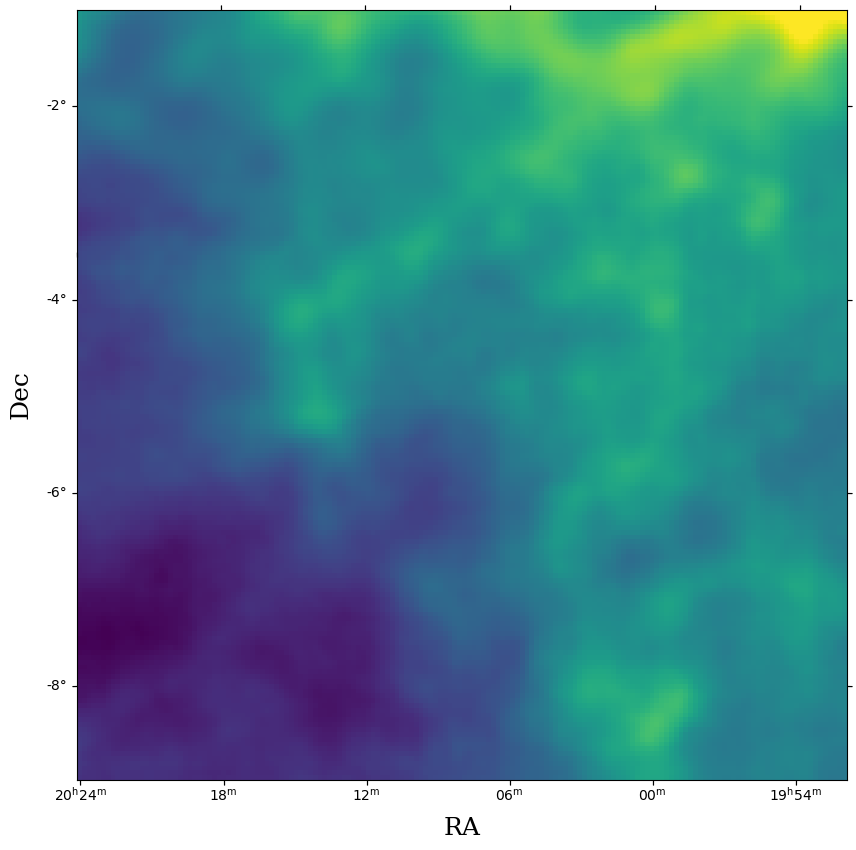

In [13]:
fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(1,1,1, projection=WCS(h_HI))
ax.imshow(d_HI, vmax=np.percentile(d_HI, 99.8))
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()

## Compare the dust and the gas data

The two data sets should show a liner correlation. The more dust we have in a region, the more N(HI) we expect.

Note, it is importnat to match the two 2D arrays. To check that the two arrays are aligned, we will plot the images and make an overlay.

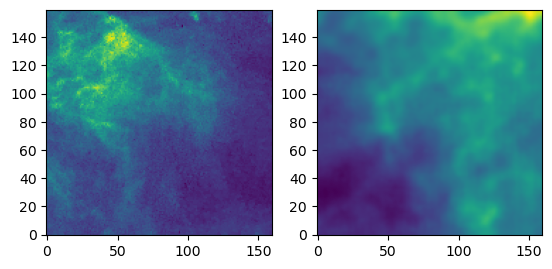

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
plt.imshow(Av)
ax1.invert_yaxis()

ax2 = fig.add_subplot(1,2,2)
plt.imshow(d_HI)
ax2.invert_yaxis()

plt.show()

<b> The orientation of the two images does not match!</b>

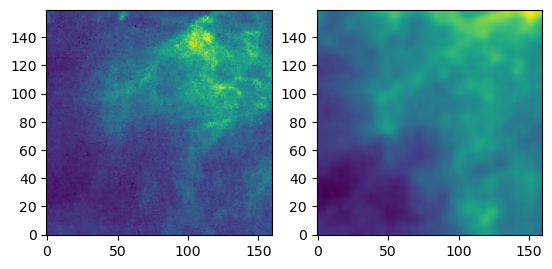

In [15]:
# lets make the two images match. We need to reverse the RA direction for the dust map

Av2 = Av[:, ::-1]

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
plt.imshow(Av2)
ax1.invert_yaxis()

ax2 = fig.add_subplot(1,2,2)
plt.imshow(d_HI)
ax2.invert_yaxis()

plt.show()

### Lets make an overlay of the dust map with N(HI) contours

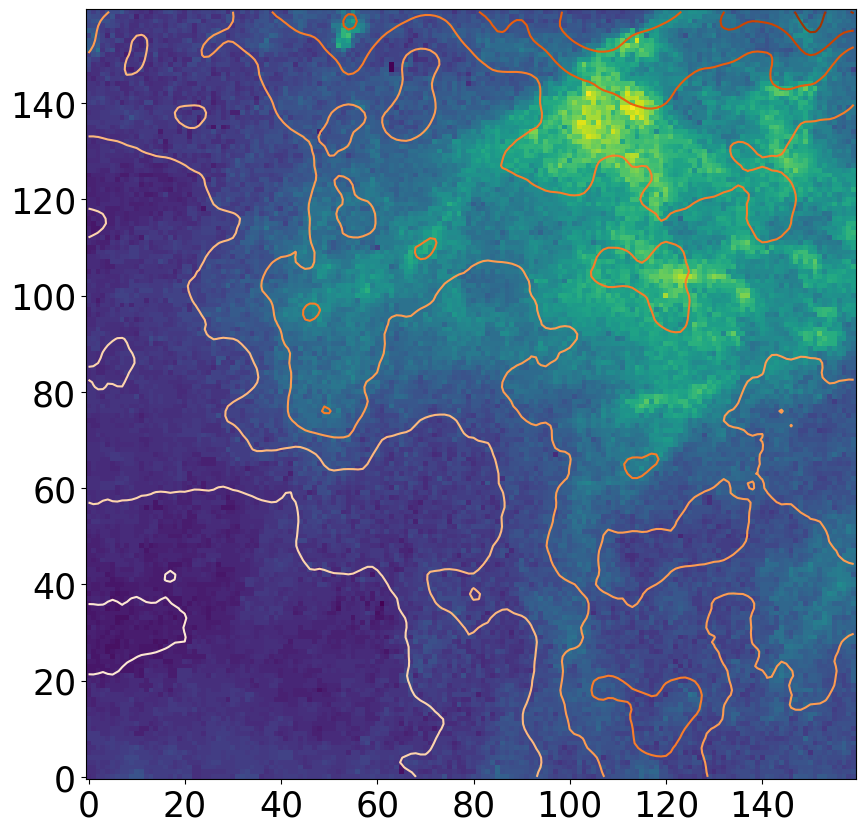

In [16]:
# making an overlay

fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(1,1,1)
ax.imshow(Av2)
ax.contour(d_HI, levels=10, cmap='Oranges')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.invert_yaxis()
plt.show()

### Comparing the E(B-V) to the N(HI) data

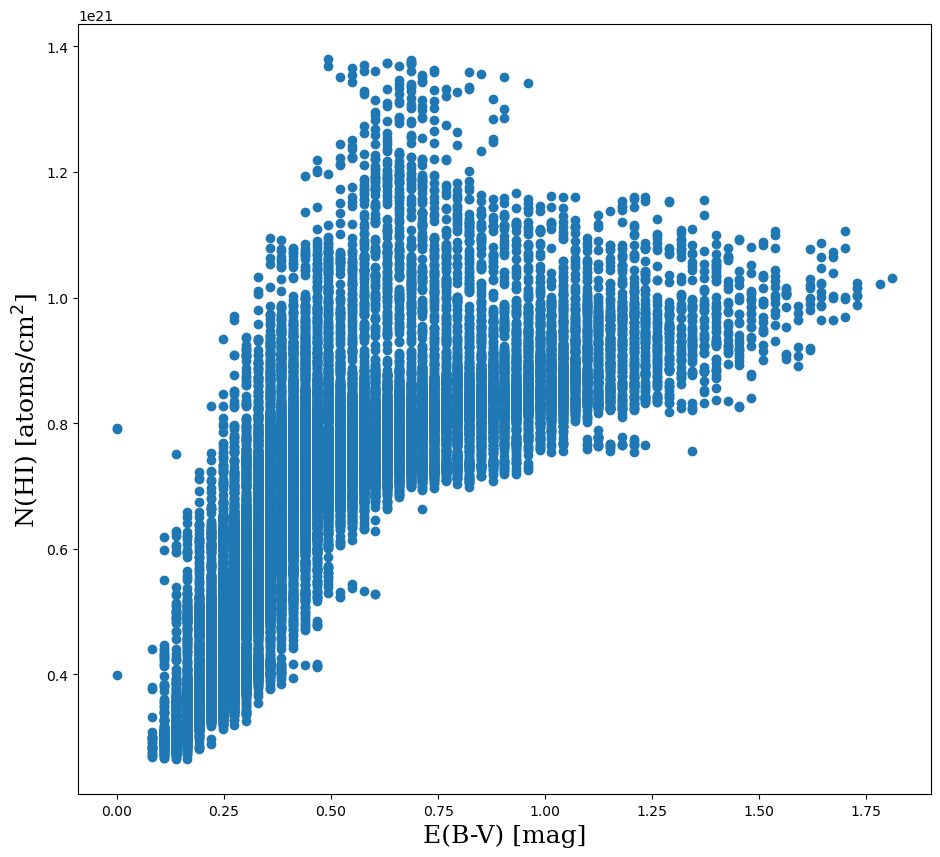

In [17]:
# compare E(B-V) to N(HI)

fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(1,1,1)
plt.scatter(Av2, d_HI)
ax.set_xlabel('E(B-V) [mag]', size=18,family='serif')
ax.set_ylabel(r'N(HI) [atoms/cm$^2$]', size=18,family='serif')
plt.show()

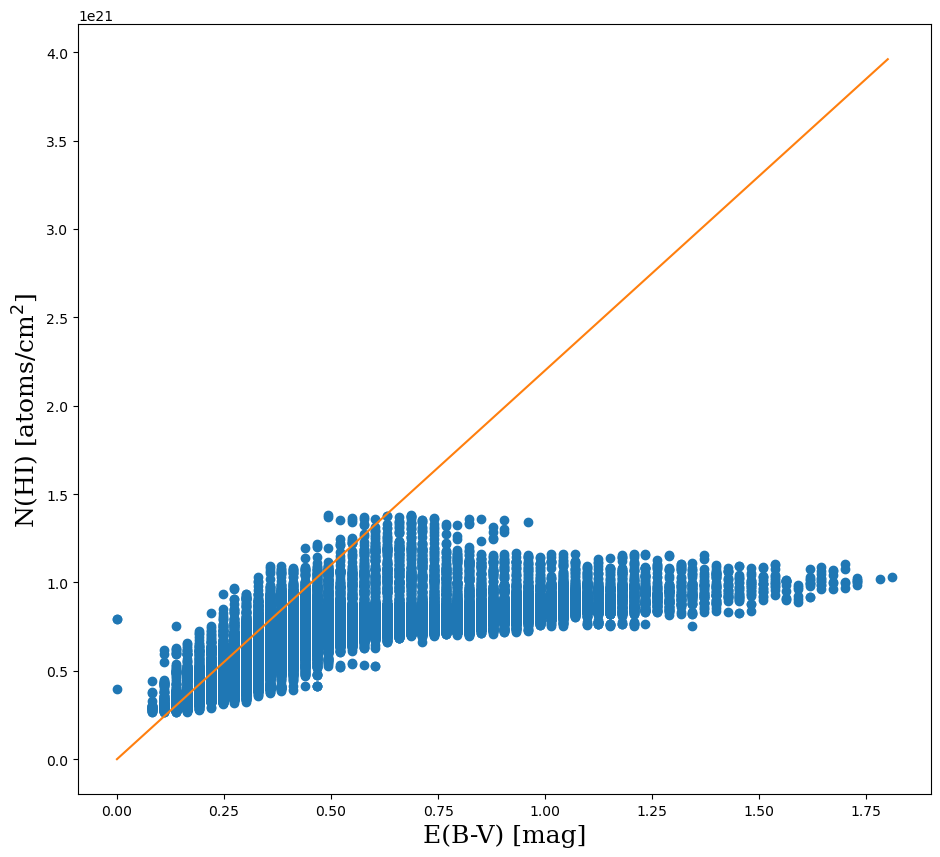

In [18]:
# lets add a model from a scientic paper
# relation from Güver and Özel 2009 (doi:10.1111/j.1365-2966.2009.15598.x)

ebv_range = np.arange(np.min(Av), np.max(Av), 0.1)
line = ebv_range * 2.2 * 10**21

fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(1,1,1)
plt.scatter(Av2, d_HI)
plt.plot(ebv_range, line, color='C1')
ax.set_xlabel('E(B-V) [mag]', size=18,family='serif')
ax.set_ylabel(r'N(HI) [atoms/cm$^2$]', size=18,family='serif')
plt.show()

The model seems to fit the data at small E(B-V) but not at higher values. Where the HI column density becomes less then expected.

## What is the reason of the discrepancy?